In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import numpy as np 
from tqdm.notebook import tqdm 
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

# Load

In [4]:
transforms_simple = T.Compose([
    T.ToTensor(), 
])

train_folder = ImageFolder('tiny-imagenet-200/train', transform=transforms_simple)
val_folder = ImageFolder('tiny-imagenet-200/val', transform=transforms_simple)
test_folder = ImageFolder('tiny-imagenet-200/test', transform=transforms_simple)


train_loader = torch.utils.data.DataLoader(
    train_folder,
    batch_size=128,
    shuffle=True,
    num_workers=16
)

val_loader = torch.utils.data.DataLoader(
    val_folder,
    batch_size=128,
    shuffle=True,
    num_workers=16
)

test_loader = torch.utils.data.DataLoader(
    test_folder,
    batch_size=128,
    shuffle=True,
    num_workers=16
)

In [5]:
mean = torch.zeros(3, dtype=float)
mean_sq = torch.zeros(3, dtype=float)
n = len(train_loader)

for x, _ in train_loader:
    mean += torch.mean(x, dim=(0, 2, 3))
    mean_sq += torch.mean(x ** 2, dim=(0, 2, 3))

mean /= n
mean_sq /= n
std = torch.sqrt(mean_sq - mean ** 2)

In [6]:
mean

tensor([0.4802, 0.4481, 0.3975], dtype=torch.float64)

In [7]:
std

tensor([0.2770, 0.2691, 0.2821], dtype=torch.float64)

In [8]:
def tensor_to_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
    # mean, std ->
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]

    renormalized_tensor = mean + std * tensor
    image = renormalized_tensor.permute(1, 2, 0).detach().cpu().numpy()

    return image

In [9]:
num_classes = len(train_folder.class_to_idx)

# Model

In [10]:
model = torchvision.models.GoogLeNet()

/home/denis/miniconda3/lib/python3.10/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [11]:
x = torch.randn(size=(64, 3, 224, 224))

In [12]:
model(x)

GoogLeNetOutputs(logits=tensor([[-0.0904, -0.0346,  0.2383,  ...,  0.0234, -0.0612, -0.0450],
        [-0.0503,  0.1403,  0.2505,  ...,  0.1595,  0.1358, -0.1225],
        [ 0.0295,  0.1712,  0.1822,  ..., -0.0428,  0.0453, -0.1249],
        ...,
        [-0.0184,  0.1551,  0.3455,  ...,  0.0807,  0.0710,  0.1599],
        [ 0.0992,  0.0832,  0.1853,  ...,  0.2322,  0.1188,  0.0349],
        [-0.0242,  0.0131,  0.3449,  ..., -0.0069, -0.2287, -0.1564]],
       grad_fn=<AddmmBackward0>), aux_logits2=tensor([[-0.0916, -0.0648, -0.0915,  ..., -0.2197,  0.0217,  0.2769],
        [-0.1986,  0.1172, -0.1483,  ...,  0.0296,  0.1006,  0.0825],
        [ 0.1765,  0.0647,  0.0667,  ..., -0.0886, -0.1305,  0.0376],
        ...,
        [ 0.0047,  0.0504,  0.0487,  ..., -0.1174, -0.2523,  0.0206],
        [-0.1777, -0.0349, -0.1528,  ..., -0.0964,  0.1162,  0.1634],
        [-0.0320, -0.0071, -0.0380,  ...,  0.1406,  0.0603, -0.0623]],
       grad_fn=<AddmmBackward0>), aux_logits1=tensor([[ 0.0497

In [13]:
model.conv1 = nn.Conv2d(3, 192, kernel_size=7, stride=1, padding=0)
model.conv2 = nn.Identity()
model.conv3 = nn.Identity()
model.maxpool2 = nn.Identity()

In [14]:
x = torch.randn(size=(64, 3, 64, 64))

In [15]:
output = model(x)

In [16]:
output.aux_logits1

tensor([[ 0.0111,  0.0105, -0.0724,  ...,  0.1127,  0.0096,  0.1245],
        [-0.1483,  0.0340,  0.0853,  ...,  0.0449, -0.0145,  0.0956],
        [ 0.0172,  0.0025, -0.2239,  ..., -0.2397,  0.1608,  0.1327],
        ...,
        [-0.0627, -0.0690,  0.0900,  ...,  0.1117,  0.0447,  0.0211],
        [-0.0111,  0.1299, -0.1429,  ...,  0.1177,  0.0674,  0.1810],
        [-0.0124, -0.1700,  0.0061,  ...,  0.1732,  0.0540,  0.0401]],
       grad_fn=<AddmmBackward0>)

In [17]:
output.aux_logits2

tensor([[-0.2154,  0.0481,  0.0331,  ...,  0.1148, -0.1310, -0.0960],
        [-0.0074, -0.0676,  0.0359,  ...,  0.1814, -0.1694,  0.0574],
        [ 0.0882,  0.1299, -0.0455,  ...,  0.0230, -0.1977, -0.1973],
        ...,
        [ 0.1367, -0.1174,  0.1432,  ...,  0.0313, -0.1833, -0.0070],
        [ 0.1102,  0.0829, -0.2374,  ..., -0.2309, -0.0464,  0.1153],
        [ 0.0038,  0.1656,  0.0906,  ..., -0.0721, -0.0625, -0.2257]],
       grad_fn=<AddmmBackward0>)

In [18]:
output.logits

tensor([[-0.1151, -0.0124,  0.2607,  ...,  0.0035, -0.0752, -0.1208],
        [-0.0427,  0.0281,  0.1456,  ..., -0.0306,  0.0027, -0.1145],
        [-0.0279,  0.0223,  0.2120,  ...,  0.0106, -0.0478, -0.0817],
        ...,
        [-0.1688,  0.0154,  0.1506,  ...,  0.0662,  0.0583, -0.0531],
        [-0.0084,  0.1936,  0.2095,  ...,  0.1120,  0.0652,  0.0643],
        [-0.0254,  0.1272,  0.4429,  ...,  0.1021,  0.1358,  0.0779]],
       grad_fn=<AddmmBackward0>)

# Wandb

# Train

In [19]:
import wandb

config = {
    "learning_rate": 3e-3,
    "weight_decay": 0.05,
    "batch_size": 128,
    "num_epochs": 25,
    "optimizer": torch.optim.AdamW,
}

wandb.init(
    # set the wandb project where this run will be logged
    project="hw2",
    name="HooLeNetTorch",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: grach0v (cowboy_bebop). Use `wandb login --relogin` to force relogin


In [20]:
def tensor_to_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
    # mean, std ->
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]

    renormalized_tensor = mean + std * tensor
    image = renormalized_tensor.permute(1, 2, 0).detach().cpu().numpy()

    return image

In [21]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [22]:
transforms_simple = T.Compose([
    T.ToTensor(), 
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=15),
    T.Normalize(mean, std) # по-хорошему нужно брать из датасета
])

train_folder = ImageFolder('tiny-imagenet-200/train', transform=transforms_simple)
val_folder = ImageFolder('tiny-imagenet-200/val', transform=transforms_simple)
test_folder = ImageFolder('tiny-imagenet-200/test', transform=transforms_simple)


train_loader = torch.utils.data.DataLoader(
    train_folder,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=16
)

val_loader = torch.utils.data.DataLoader(
    val_folder,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=16
)

test_loader = torch.utils.data.DataLoader(
    test_folder,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=16
)

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = config["optimizer"](
    model.parameters(), 
    lr=config["learning_rate"], 
    weight_decay=config["weight_decay"]
)

In [24]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    # v NOTE THIS v
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()
    # ^ NOTE THIS ^

    model = model.to(device)

    losses = []
    for batch in tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        xs, ys_true = batch

        # ys_pred = model(xs.to(device))
        # loss = loss_fn(ys_pred, ys_true.to(device))

        ys_true = ys_true.to(device)

        output = model(xs.to(device))

        if stage == "train":
            o1 = output.aux_logits1
            o2 = output.aux_logits2
            o3 = output.logits

            loss1 = loss_fn(o1, ys_true)
            loss2 = loss_fn(o2, ys_true)
            loss3 = loss_fn(o3, ys_true)

            loss = 0.3 * loss1 + 0.3 * loss2 + 0.4 * loss3


            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            wandb.log({"lr": optimizer.param_groups[0]["lr"], "loss": loss})

        else:
            loss = loss_fn(output, ys_true)

        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

In [25]:
def save_checkpoint(model, filename):

    with open(filename, "wb") as fp:
        torch.save(model.state_dict(), fp)


def load_checkpoint(model, filename):

    with open(filename, "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(state_dict)

In [26]:
def run_experiment(
    model, dataloader_train, dataloader_val, 
    loss_fn, optimizer, num_epochs, 
    device, output_dir, start_epoch=0
):
    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    os.makedirs(output_dir, exist_ok=True)

    for epoch in range(start_epoch, start_epoch + num_epochs):
        train_loss = run_epoch("train", model, dataloader_train, loss_fn, optimizer, epoch, device)
        train_losses.append(train_loss)

        val_loss = run_epoch("val", model, dataloader_val, loss_fn, optimizer, epoch, device)
        val_losses.append(val_loss)

        wandb.log({"epoch_loss_train": train_loss, "epoch_loss_val": val_loss, "epoch": epoch})

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            output_fn = os.path.join(output_dir, f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar")
            save_checkpoint(model, output_fn)
            print(f"New checkpoint saved to {output_fn}\n")

            best_val_loss_fn = output_fn

    print(f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
    load_checkpoint(model, best_val_loss_fn)

    return train_losses, val_losses, best_val_loss, model


In [27]:
train_losses_baseline, val_losses_baseline, best_val_loss_baseline, cnn_baseline = run_experiment(
    model,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    config["num_epochs"],
    device,
    "checkpoints_HooLeNetTorch",
)

epoch: 000 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 000 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorch/epoch=00_valloss=4.298.pth.tar



epoch: 001 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 001 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorch/epoch=01_valloss=4.138.pth.tar



epoch: 002 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 002 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorch/epoch=02_valloss=3.377.pth.tar



epoch: 003 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 003 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorch/epoch=03_valloss=3.247.pth.tar



epoch: 004 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 004 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorch/epoch=04_valloss=3.146.pth.tar



epoch: 005 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 005 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorch/epoch=05_valloss=2.925.pth.tar



epoch: 006 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 006 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 007 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 007 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorch/epoch=07_valloss=2.841.pth.tar



epoch: 008 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 008 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorch/epoch=08_valloss=2.654.pth.tar



epoch: 009 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 009 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 010 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 010 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorch/epoch=10_valloss=2.605.pth.tar



epoch: 011 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 011 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorch/epoch=11_valloss=2.524.pth.tar



epoch: 012 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 012 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 013 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 013 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorch/epoch=13_valloss=2.413.pth.tar



epoch: 014 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 014 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorch/epoch=14_valloss=2.359.pth.tar



epoch: 015 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 015 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 016 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 016 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 017 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 017 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 018 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 018 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 019 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 019 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorch/epoch=19_valloss=2.319.pth.tar



epoch: 020 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 020 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 021 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 021 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNetTorch/epoch=21_valloss=2.232.pth.tar



epoch: 022 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 022 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 023 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 023 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 024 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 024 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

Best val_loss = 2.232 reached at epoch 21


In [28]:
def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(12, 5))
    plt.title(title)
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True)
    plt.legend()
    plt.show()

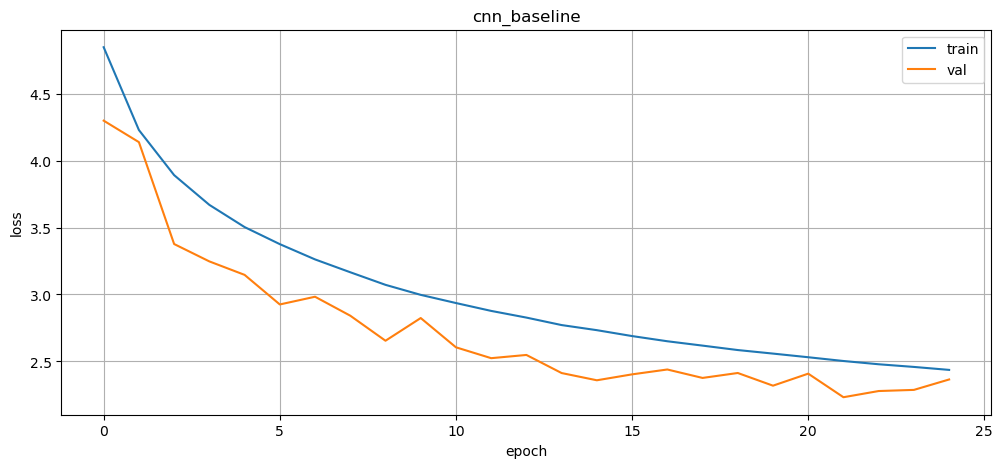

In [29]:
plot_losses(train_losses_baseline, val_losses_baseline, title="cnn_baseline")

In [30]:
def collect_predictions(model, dataloader, device):
    model.eval()
    model = model.to(device)
    torch.set_grad_enabled(False)

    labels_all = []
    probs_all = []
    preds_all = []
    for batch in tqdm(dataloader, total=len(dataloader)):
        images, labels = batch

        logits = model(images.to(device)).cpu()
        probs = logits.softmax(dim=1)
        max_prob, max_prob_index = torch.max(probs, dim=1)

        labels_all.extend(labels.numpy().tolist())
        probs_all.extend(max_prob.numpy().tolist())
        preds_all.extend(max_prob_index.numpy().tolist())

    return labels_all, probs_all, preds_all

In [31]:
train_labels, train_probs, train_preds = collect_predictions(cnn_baseline, train_loader, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

  0%|          | 0/782 [00:00<?, ?it/s]

0.57349

In [32]:
test_labels, test_probs, test_preds = collect_predictions(cnn_baseline, test_loader, device)

accuracy_train = accuracy_score(test_labels, test_preds)
accuracy_train

  0%|          | 0/79 [00:00<?, ?it/s]

0.0024

In [33]:
optimizer = config["optimizer"](
    model.parameters(), 
    lr=config["learning_rate"] * 10, 
    weight_decay=config["weight_decay"]
)

In [35]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch_loss_train,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch_loss_val,█▇▅▄▄▃▄▃▂▃▂▂▂▂▁▂▂▁▂▁▂▁▁▁▁
loss,██▆▆▅▅▅▅▄▄▃▄▄▃▃▄▃▃▃▂▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▇
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
epoch,24
epoch_loss_train,2.43644
epoch_loss_val,2.36495
loss,4.79775
lr,0.03
